In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available() #GPU 실행
device = torch.device('cuda' if is_cuda else 'cpu')

In [2]:
device

device(type='cuda')

In [8]:
print(torch.__version__)

2.3.0+cu121


In [3]:
#standardization code
standardizator = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5,),
                         std=(0.5,)) # 3 for RGB channels
])

#MNIST datasets
train_dataset = datasets.MNIST(root='data/',
                          train=True,
                          transform=standardizator,
                          download=True)
test_dataset = datasets.MNIST(root='data/',
                          train=False,
                          transform=standardizator,
                          download=True)

batch_size = 200 #modify parameter for your Laptop
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle = True)

# Print shape of images in train_data_loader
example_mini_batch_img, example_mini_batch_label = next(iter(train_data_loader))
print(f'Image batch shape: {example_mini_batch_img.shape}')
print(f'Label batch shape: {example_mini_batch_label.shape}')


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17407304.81it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 482508.52it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4414741.61it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4668103.10it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Image batch shape: torch.Size([200, 1, 28, 28])
Label batch shape: torch.Size([200])


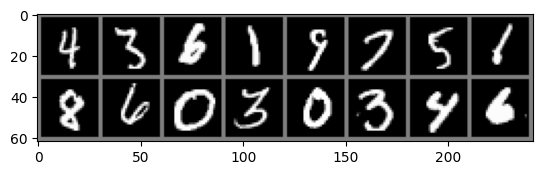

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
  img = (img+1)/2
  img = img.squeeze()
  np_img = img.numpy()
  plt.imshow(np_img, cmap = 'gray')
  plt.show()

def imshow_grid(img):
  img = utils.make_grid(img.cpu().detach())
  img = (img+1)/2
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

#train_data_loader에서는 흑백이미지를 받는다.
example_mini_batch_img, example_mini_batch_label = next(iter(train_data_loader))
#print(example_mini_batch_img.shape)
imshow_grid(example_mini_batch_img[0:16,:,:])


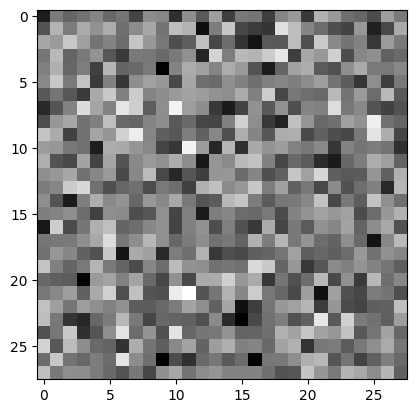

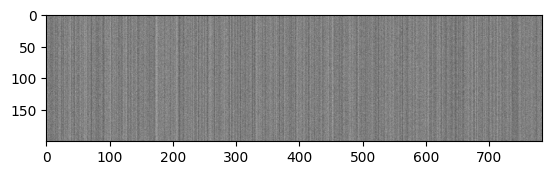

In [10]:
#noise vector의 차원
d_noise = 100
#hidden layer의 차원 = 층의 개수
d_hidden = 256

def sample_z(batch_size = 1, d_noise=100):
  return torch.randn(batch_size, d_noise, device=device)

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,28*28),
    nn.Tanh()
).to(device)

#노이즈 생성
z = sample_z()
img_fake = G(z).view(-1,28,28)
#이미지 출력
imshow(img_fake.squeeze().cpu().detach())

#Batch size만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = G(z)
imshow_grid(img_fake)

In [11]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,1),
    nn.Sigmoid()
).to(device)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))


torch.Size([200, 784])
torch.Size([200, 1])
tensor([[0.4931, 0.4911, 0.4919, 0.4884, 0.4898]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [15]:
criterion = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):

    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:

        img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 28*28))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        loss_d    = (loss_real + loss_fake).mean()

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + \    #
        #          criterion(p_fake, torch.zeros_like(p_real).to(device))       #

        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        # init optimizer
        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #

        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        loss_g = -1 * torch.log(p_fake).mean()

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()

        # Update parameters
        _optimizer_g.step()

def evaluate_model(generator, discriminator):

    p_real, p_fake = 0.,0.

    generator.eval()
    discriminator.eval()

    for img_batch, label_batch in test_data_loader:

        img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.

    return p_real, p_fake

(epoch 10/200) p_real: 0.993314, p_g: 0.012182


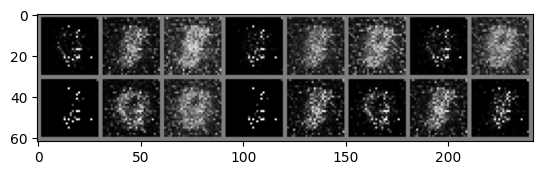

(epoch 20/200) p_real: 0.940055, p_g: 0.077594


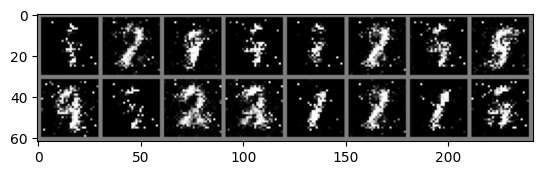

(epoch 30/200) p_real: 0.862780, p_g: 0.114329


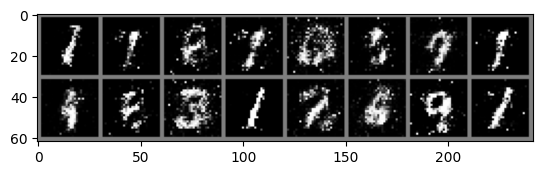

(epoch 40/200) p_real: 0.802992, p_g: 0.139538


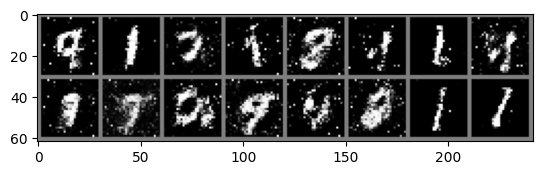

(epoch 50/200) p_real: 0.785164, p_g: 0.240424


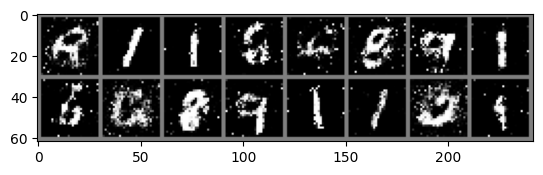

(epoch 60/200) p_real: 0.717142, p_g: 0.260492


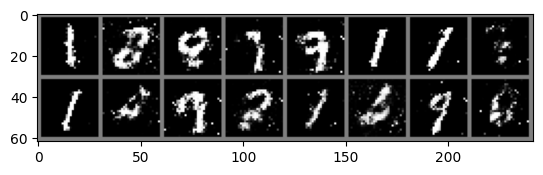

(epoch 70/200) p_real: 0.682810, p_g: 0.300093


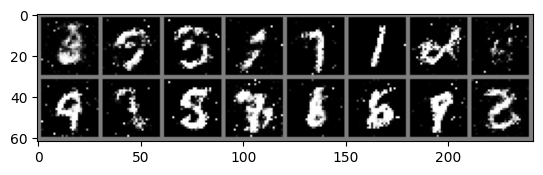

(epoch 80/200) p_real: 0.683595, p_g: 0.316223


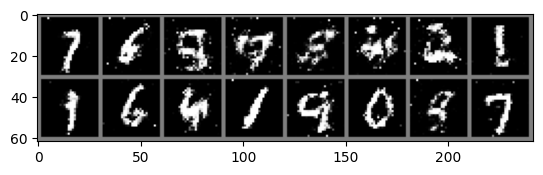

(epoch 90/200) p_real: 0.661767, p_g: 0.330633


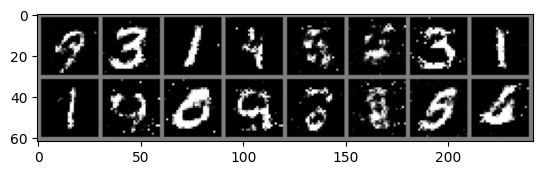

(epoch 100/200) p_real: 0.637947, p_g: 0.315307


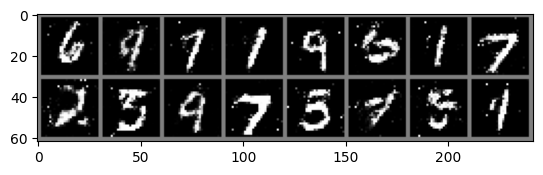

(epoch 110/200) p_real: 0.621764, p_g: 0.329100


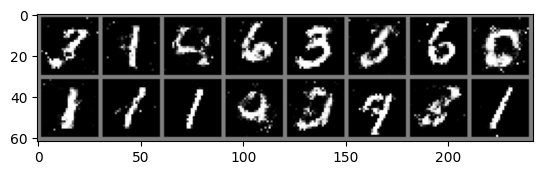

(epoch 120/200) p_real: 0.636276, p_g: 0.304182


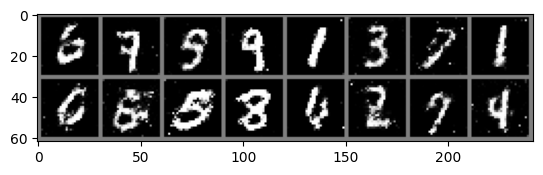

(epoch 130/200) p_real: 0.618560, p_g: 0.338240


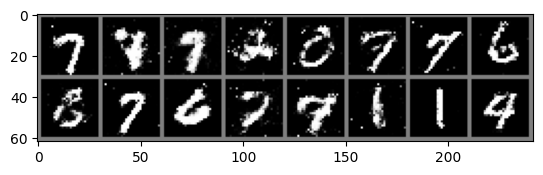

(epoch 140/200) p_real: 0.606340, p_g: 0.322915


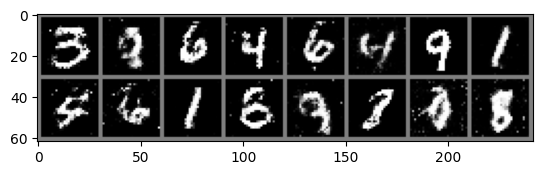

(epoch 150/200) p_real: 0.638091, p_g: 0.352096


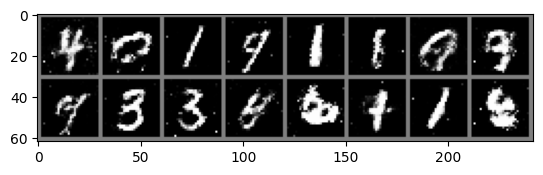

(epoch 160/200) p_real: 0.602361, p_g: 0.267435


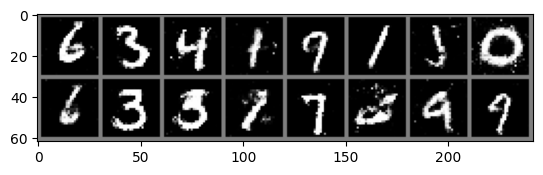

(epoch 170/200) p_real: 0.616700, p_g: 0.340623


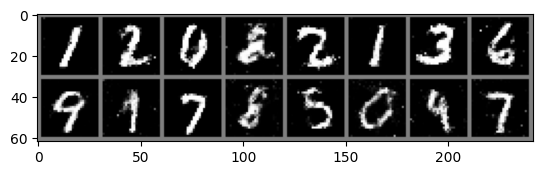

(epoch 180/200) p_real: 0.619309, p_g: 0.384189


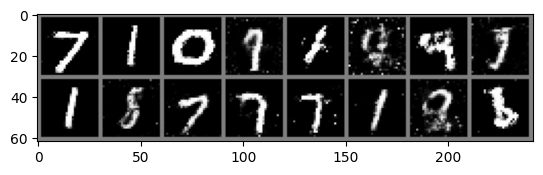

KeyboardInterrupt: 

In [17]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(200):

    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)

    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake)

    if((epoch+1)% 10 == 0):
        print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

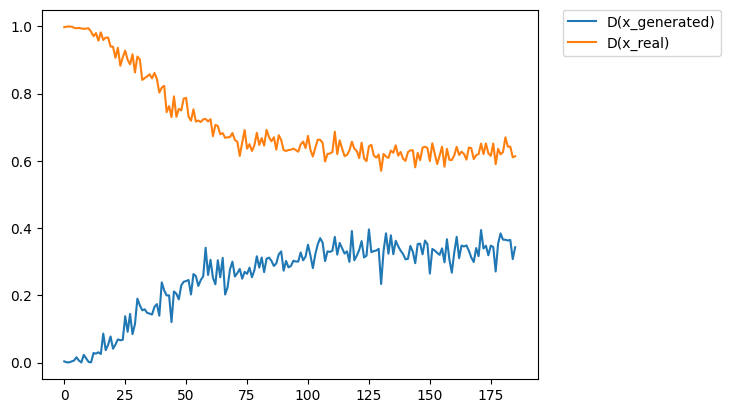

In [19]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()